## Importing Libraries

In [11]:
import re
import math
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Set the global parameters using rcParams
plt.rcParams['axes.titlesize'] = 20     # title size
plt.rcParams['axes.labelsize'] = 18     # axis label size
plt.rcParams['xtick.labelsize'] = 15    # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 15    # y-axis tick label size

## Loading Data

In [3]:
# reading the data from the directory
summary = pd.read_excel("dental_claim_data.xlsx", sheet_name = 0)
data = pd.read_excel("dental_claim_data.xlsx", sheet_name = 1)

## EDA

**View Data** <br>
To view what your data actually looks like, use the **head** function.

In [3]:
# Checking data preview
data.head()

,ee_id,policy number,member_id,language,gender,pol_renewal_dt,days_exposure_dental,num_claims,total_num_serv_lines,sum_charge_amt,...,ftr_env_pct_household_2person,ftr_env_pct_household_3person,ftr_env_pct_household_4person,ftr_env_pct_household_5person,pol_renewal_yr,ftr_years_since_cert_effective,ftr_age_at_renewal,MARKET_SEGMENT_ADJ,industry,province
0,3433_3433,3433,3433,E,M,2018-06-01,365,NaN,NaN,NaN,...,0.272997,0.181009,0.148368,0.183976,2018,1.750685,50.750685,SUNADVANTAGE,retail_trade,ontario
1,3433_38,3433,38,E,M,2017-06-01,365,NaN,NaN,NaN,...,0.483271,0.111524,0.083643,0.029740,2017,5.254795,54.613699,SUNADVANTAGE,retail_trade,ontario
2,3447_8,3447,8,E,F,2019-06-01,366,5.0,16.0,1366.0,...,0.327586,0.068966,0.034483,0.000000,2019,11.257534,51.739726,SUNADVANTAGE,service_repair_business,ontario
3,3473_9,3473,9,E,M,2017-06-01,365,NaN,NaN,NaN,...,0.314815,0.055556,0.018519,0.000000,2017,9.257534,45.279452,SUNSOLUTIONS,service_repair_business,saskatchewan
4,3498_1073,3498,1073,E,M,2019-07-01,366,2.0,8.0,402.0,...,0.434783,0.130435,0.173913,0.043478,2019,0.246575,47.646575,SUNADVANTAGE,manufacturing,ontario


**Shape of Data** <br>
This will give you an idea about how large your dataset is.

In [4]:
# Checking the shape of the data
print(data.shape)

(8000, 233)


**Check for data types** <br>
This will tell you about which variable is categorical and which variable is numerical. 

In [10]:
# Checking the data types of each feature
print(data.dtypes)

ee_id                              object
policy number                       int64
member_id                          object
language                           object
gender                             object
                                   ...   
ftr_years_since_cert_effective    float64
ftr_age_at_renewal                float64
MARKET_SEGMENT_ADJ                 object
industry                           object
province                           object
Length: 233, dtype: object


**Check for Missing Values** <br>
Missing values need to be treated carefully as they may lead to wrong prediction or classification for any given model being used.

In [6]:
# Checking for missing values
print(data.isnull().sum())

ee_id                             0
policy number                     0
member_id                         0
language                          0
gender                            0
                                 ..
ftr_years_since_cert_effective    0
ftr_age_at_renewal                0
MARKET_SEGMENT_ADJ                2
industry                          0
province                          0
Length: 233, dtype: int64


**Summary Statistics** <br>
This gives statistical information about numerical columns in the dataset.

In [7]:
# Descriptive statistics
print(data.describe())

       policy number  days_exposure_dental   num_claims  total_num_serv_lines  \
count    8000.000000           8000.000000  5051.000000           5051.000000   
mean    83225.450125            314.606500     5.314591             14.934666   
std     57741.340551             99.948519     4.427571             12.082607   
min      3433.000000              1.000000     1.000000              1.000000   
25%     25277.000000            344.000000     2.000000              6.000000   
50%     78180.000000            365.000000     4.000000             11.000000   
75%    150237.250000            365.000000     7.000000             20.000000   
max    187990.000000            366.000000    49.000000            114.000000   

       sum_charge_amt  sum_paid_amt  sum_adj_amt  sum_paid_amt_cldld  \
count     5051.000000   5051.000000  5051.000000         5051.000000   
mean      1814.719036   1100.486163  1088.407462         1180.342465   
std       2221.059836   1109.119092  1101.929518      

**Checking for Duplicates** <br>
You may want to check if your dataset has any duplicate rows.

In [11]:
# Checking duplicates
data.duplicated().sum()

0

**Outlier Detection** <br>
Outliers can be detected visually using box plots and histograms, or mathematically using techniques like the Z-score or IQR method. Here's a simple boxplot:

In [7]:
numerical_cols = data.select_dtypes(include=[np.number])

# Filling NaN values with the mean of the respective column
numerical_cols = numerical_cols.fillna(numerical_cols.mean())

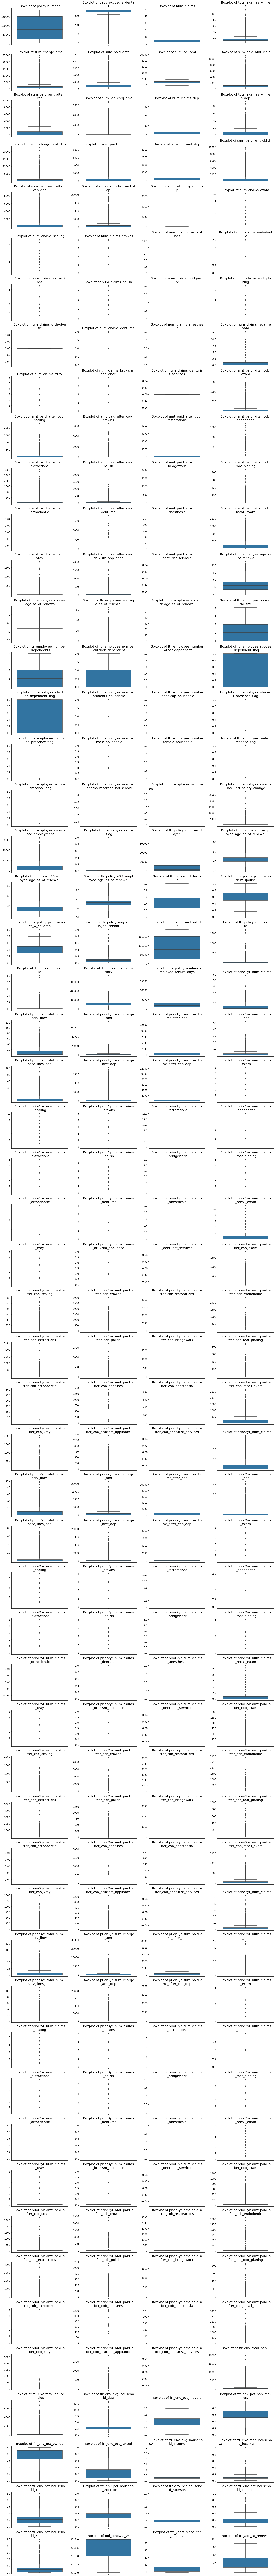

In [41]:
# Determine the number of columns
num_cols = len(numerical_cols.columns)

# Determine the number of rows in subplots, if number of columns are 4 in subplots
num_rows = math.ceil(num_cols / 4)

# Create a grid of subplots
fig, axs = plt.subplots(num_rows, 4, figsize = (24, num_rows * 4))
axes = axs.ravel()


# Plotting boxplots
for i, column in enumerate(numerical_cols):
    sns.boxplot(y = numerical_cols[column], ax=axes[i])
    title = f'Boxplot of {column}'
    title = title if len(title) <= 30 else title[:30] + '\n' + title[30:] # If the title is longer than 30 letters, a new line is created
    axes[i].set_title(title)
    axes[i].set_ylabel('') # remove y-label

plt.tight_layout()
plt.show()

### Box plot Explanation

- The **lower edge (bottom line) of the box** indicates the first quartile or 25th percentile (Q1). This is the point at which 25% of the data fall below.

- The **upper edge (top line) of the box** indicates the third quartile or 75th percentile (Q3). This means 75% of the data fall below this point.

- The **line inside the box** usually denotes the second quartile or median (50th percentile), i.e., 50% of the data falls below this line.

- The **whiskers** of the boxplot, the lines extending from the box indicating variability outside the upper and lower quartiles, hence also called the interquartile range (IQR). They can also represent minimum and maximum values of the data when no outlier is present.

- The **dots or points** that fall below the bottom whisker or above the upper whisker are considered as **outliers**. These are data points that are more than 1.5 times the interquartile range (IQR) away from the top or bottom of the box.

### The interpretation of these elements:

1. **Q1 (bottom line of the box):** 25% of the data points are less than or equal to this value.

2. **Q3 (top line of the box):** 75% of the data points are less than or equal to this value. The distance between Q1 and Q3 is the interquartile range (IQR), which represents the middle 50% of the data.

3. **Median (line inside the box):** This is the middle value of the dataset, i.e., 50% of the data points are less than or equal to this value.

4. **Whiskers (lines above and below the box):** These typically represent the minimum and maximum values in the data set that are not outliers or extreme values. In some boxplot representations, the whiskers represent 1.5 times the IQR below Q1 and above Q3.

5. **Outliers (dots or points above or below the whiskers):** These are the individual data points that fall outside of the whiskers. These points are more than 1.5 times the IQR away from either Q1 or Q3 and could indicate variability in your data, or they could be potential anomalies or errors.

**Value Counts**

This is useful for categorical variables and can tell you how balanced your dataset is.

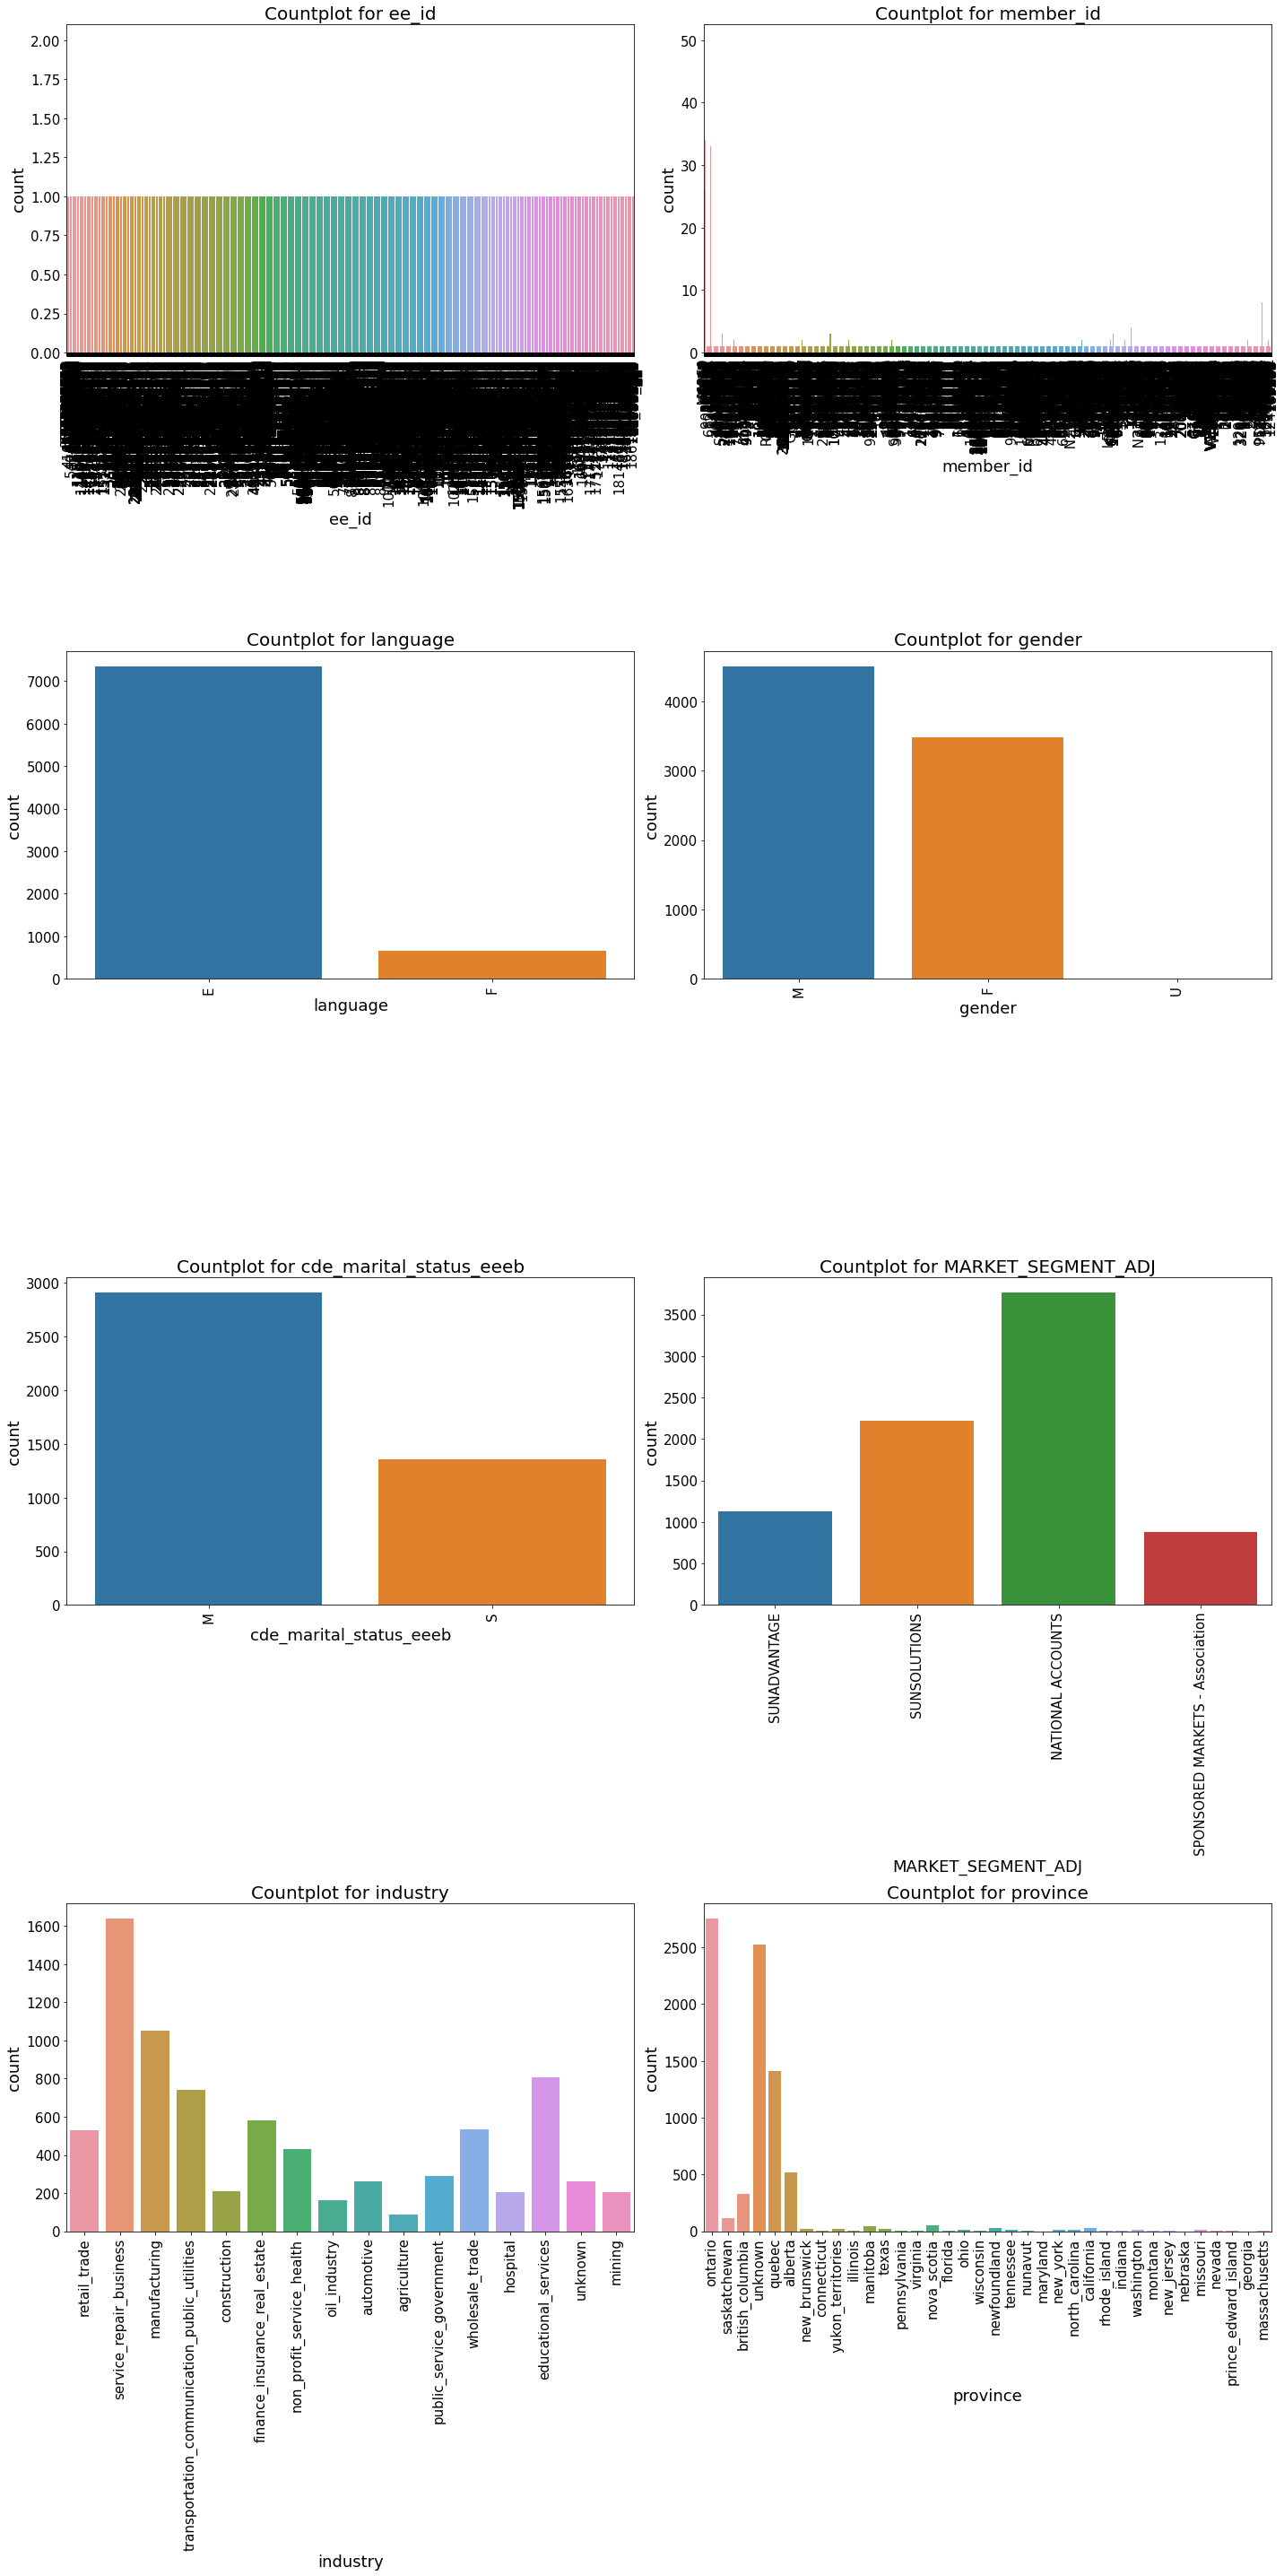

In [52]:
# Get a list of categorical column names
categorical_columns = data.select_dtypes(include=['object']).columns

# Calculate the number of rows needed for subplots
n_rows = math.ceil(len(categorical_columns) / 2)

# Define the size of the entire grid
fig, axs = plt.subplots(n_rows, 2, figsize=(20, 10*n_rows))

# Flatten the axes array to make it easier to iterate over
axs = axs.ravel()

for i, column in enumerate(categorical_columns):
    sns.countplot(data=data, x=column, ax=axs[i])
    axs[i].set_title(f'Countplot for {column}')
    axs[i].tick_params(axis='x', rotation=90)  # This line rotates x-ticks
    axes[i].set_xlabel('') # remove x-label

# Remove the unused subplots
if len(categorical_columns) % 2:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

### Interpretation of Count plot

1. **Uniform Distribution:** If the bars in the countplot subplots are roughly equal in height, it indicates a balanced distribution. This means the data is evenly distributed among the categories, without significant skew or bias towards any specific category. A balanced distribution ensures fair representation and meaningful analysis.

2. **Skewed Distribution:** Varying bar heights in the countplot subplots suggest a skewed distribution. Some categories have significantly higher bars, indicating an uneven representation of data. Skewness can result from various factors, such as data collection biases or inherent population characteristics.

3. **Class Imbalance:** If a countplot subplot represents a target variable, a notable difference in bar heights indicates class imbalance. One class dominates with a larger number of instances, while the other class(es) are in the minority. Class imbalance poses challenges in machine learning, as models may be biased towards the majority class, affecting performance on the minority class.

**Correlation Analysis**
Visualizing the pairwise correlation of 254 variables using pairplot or scatterplot matrix can be quite overwhelming and computationally intensive. A heatmap of the correlation matrix can be a much more efficient way to quickly understand the relationships between variables.

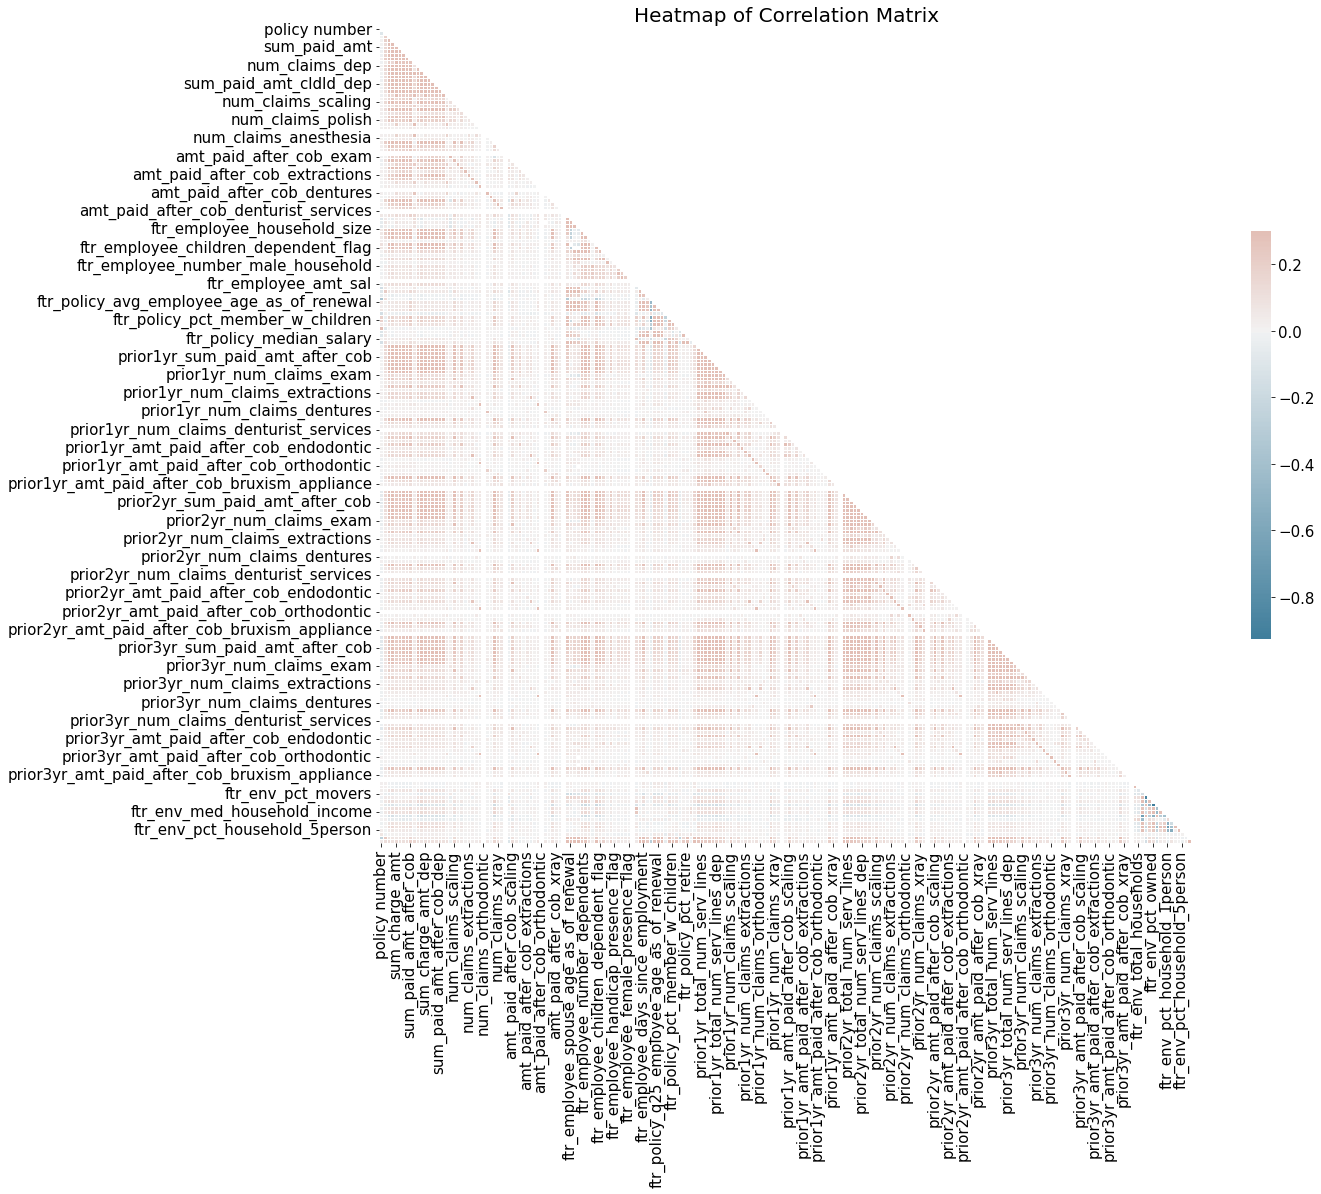

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get a list of numerical column names
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
corr = data[numerical_columns].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of Correlation Matrix')
plt.show()

### Interpretation

The correlation analysis heatmap provides insights into the relationships between the numerical variables in the dataset. The strength of the correlation is represented by the colors in the heatmap, with darker shades indicating a stronger positive correlation and lighter shades indicating a stronger negative correlation. Positive correlation is observed when an increase in one variable corresponds to an increase in another variable. On the other hand, negative correlation is observed when an increase in one variable corresponds to a decrease in another variable. Cells with light gray or white color indicate weak or no correlation between variables. By examining the heatmap, patterns and clusters of strongly correlated variables can be identified, aiding in the detection of multicollinearity and highlighting groups of variables associated with specific phenomena.

## Label Encoding

In [4]:
## Converting string data into numerical ones

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

string_cols = data.select_dtypes(include=['object']).columns

# Iterate over each column in the DataFrame
for column in string_cols:
    try:
        # Try to fit and transform the column with LabelEncoder
        data[column] = label_encoder.fit_transform(data[column])
    except:
        # Handle the ValueError when non-numeric values are present
        print(f"Non-numeric values found in column '{column}'. Preprocessing required.")
        # Remove alphabets from the column using regular expressions
        data[column] = data[column].apply(lambda x: re.sub('[^0-9]+', '', str(x)))
        data[column].replace('', np.nan, inplace=True)
        data[column] = data[column].str.strip()
        try:
            # Try to convert the column to the desired data type (e.g., float)
            data[column] = data[column].astype(float)
        except ValueError:
            # Handle the ValueError if conversion to float fails
            print(f"Could not convert column '{column}' to float. Handling required.")
            # Find the values that are not converting to float
            non_float_values = data[column].loc[~data[column].astype(str).str.isnumeric()]
            print("Non-float values:")
            print(non_float_values)

Non-numeric values found in column 'member_id'. Preprocessing required.


In [5]:
# Filling NaN values with the mean of the respective column
data = data.fillna(data.mean(numeric_only=True))

In [6]:
# Dropping date column
data = data.drop('pol_renewal_dt', axis=1)

In [7]:
# Separate the features and target variable
X = data.drop('sum_paid_amt_after_cob', axis=1)
y = data['sum_paid_amt_after_cob']

## Feature Importance

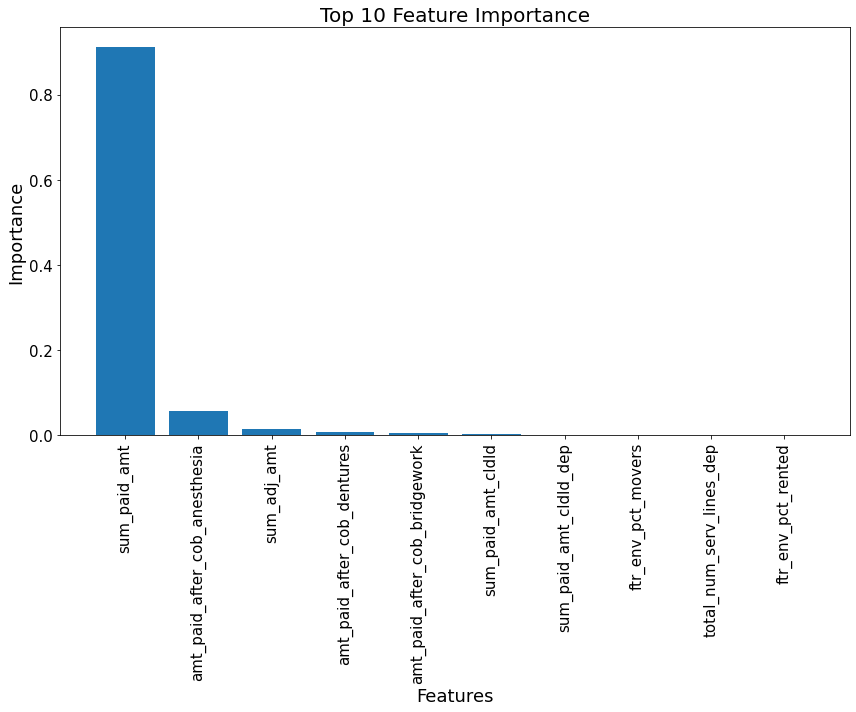

In [8]:
# Create a Random Forest regressor
RF = RandomForestRegressor()
RF.fit(X, y)

# Get feature importances
feature_importances = RF.feature_importances_

# Create a DataFrame of feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Select the top 10 features
top_10_features = importance_df.head(10)

# Plot the feature importances for the top 10 features
plt.figure(figsize=(12, 10))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

In [8]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

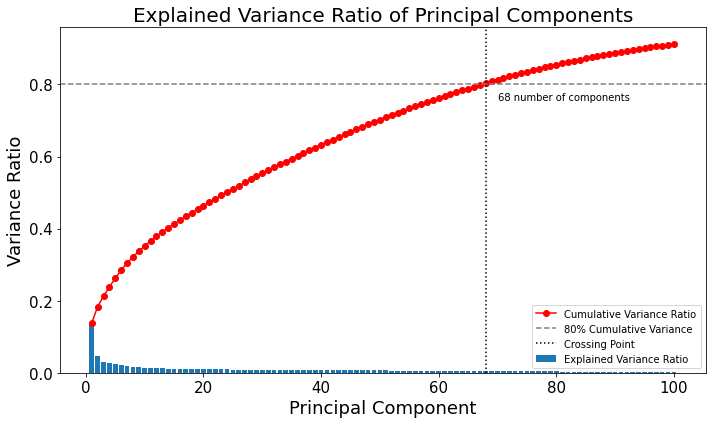

In [146]:
# Perform PCA
pca = PCA(n_components=100)  
principal_components = pca.fit_transform(X_scaled)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create a DataFrame of explained variance ratio and cumulative variance ratio
variance_df = pd.DataFrame({'Principal Component': range(1, len(explained_variance_ratio) + 1),
                            'Explained Variance Ratio': explained_variance_ratio,
                            'Cumulative Variance Ratio': cumulative_variance_ratio})

# Plot the explained variance ratio and cumulative variance ratio
plt.figure(figsize=(10, 6))
plt.bar(variance_df['Principal Component'], variance_df['Explained Variance Ratio'], label='Explained Variance Ratio')
plt.plot(variance_df['Principal Component'], variance_df['Cumulative Variance Ratio'], color='red', marker='o', label='Cumulative Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.axhline(y=0.8, color='gray', linestyle='--', label='80% Cumulative Variance')
plt.axvline(x=np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1, color='black', linestyle=':', label='Crossing Point')

# Add labels to the crossing point
crossing_point = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
plt.text(crossing_point + 2, 0.75, f'{crossing_point} number of components', color='black', ha='left', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

###  Interpretation

In the above figure the PCA is applied to the dataset 'X_scaled', reducing its dimensionality to 100 components. The variance explained by each of these components and the cumulative variance are plotted. 

The horizontal line in the figure represents the point at which 80% of the total variance in the data is explained. The vertical line intersects this at the minimum number of components required to achieve this level of explained variance. 

As can be observed from the figure, **68** components are sufficient to explain 80% of the variance in the data. This is a common practice in PCA, where retaining components that account for **80 to 90%** of the variance provides a balance between reducing the complexity of the data and maintaining the essential information within it.

In [9]:
# Considering 68 components
pca = PCA(n_components=68)  
X_pca = pca.fit_transform(X_scaled)

In [10]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

## Modeling

In [15]:
%%time
# SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)
print("SVR MSE: ", mean_squared_error(y_test, y_pred_svr))
print("SVR R2 Score: ", r2_score(y_test, y_pred_svr))

SVR MSE:  950761.2581853687
SVR R2 Score:  0.08827983191976296
Wall time: 9.7 s


In [16]:
%%time
# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost MSE: ", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2 Score: ", r2_score(y_test, y_pred_xgb))

XGBoost MSE:  178536.76839058183
XGBoost R2 Score:  0.8287944832793898
Wall time: 7.91 s


In [17]:
%%time
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print("Decision Tree MSE: ", mean_squared_error(y_test, y_pred_dt))
print("Decision Tree R2 Score: ", r2_score(y_test, y_pred_dt))

Decision Tree MSE:  379935.05156224995
Decision Tree R2 Score:  0.6356662136917111
Wall time: 1.35 s


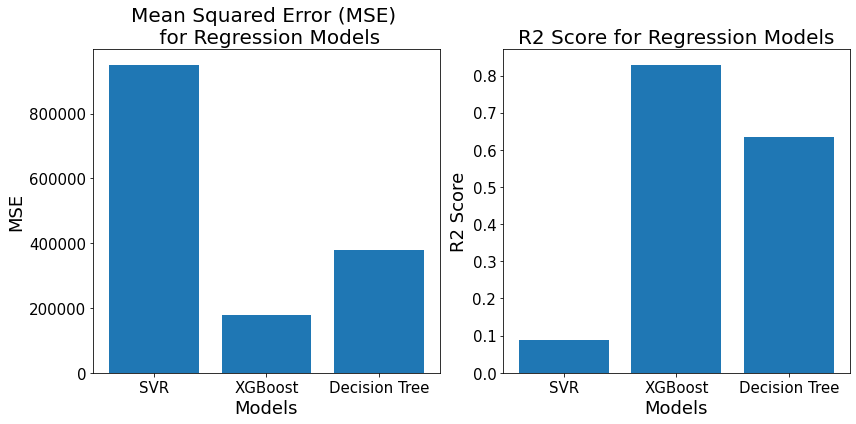

In [20]:
# Calculate MSE and R2 Score for each model
mse_scores = [mean_squared_error(y_test, y_pred_svr),
              mean_squared_error(y_test, y_pred_xgb),
              mean_squared_error(y_test, y_pred_dt)]

r2_scores = [r2_score(y_test, y_pred_svr),
             r2_score(y_test, y_pred_xgb),
             r2_score(y_test, y_pred_dt)]

# Create a bar plot
models = ['SVR', 'XGBoost', 'Decision Tree']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE scores
ax1.bar(models, mse_scores)
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE')
ax1.set_title('Mean Squared Error (MSE) \n for Regression Models')

# Plot R2 scores
ax2.bar(models, r2_scores)
ax2.set_xlabel('Models')
ax2.set_ylabel('R2 Score')
ax2.set_title('R2 Score for Regression Models')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

### If use all variables

In [30]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
%%time
# SVR
svr_model = SVR()
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)
print("SVR MSE: ", mean_squared_error(y_test, y_pred_svr))
print("SVR R2 Score: ", r2_score(y_test, y_pred_svr))

SVR MSE:  962538.1111506495
SVR R2 Score:  0.07698657162700018
Wall time: 19.7 s


In [32]:
%%time
# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost MSE: ", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2 Score: ", r2_score(y_test, y_pred_xgb))

XGBoost MSE:  518.6412624430617
XGBoost R2 Score:  0.9995026556931123
Wall time: 5.74 s


In [33]:
%%time
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print("Decision Tree MSE: ", mean_squared_error(y_test, y_pred_dt))
print("Decision Tree R2 Score: ", r2_score(y_test, y_pred_dt))

Decision Tree MSE:  675.9314906250005
Decision Tree R2 Score:  0.9993518242703541
Wall time: 757 ms


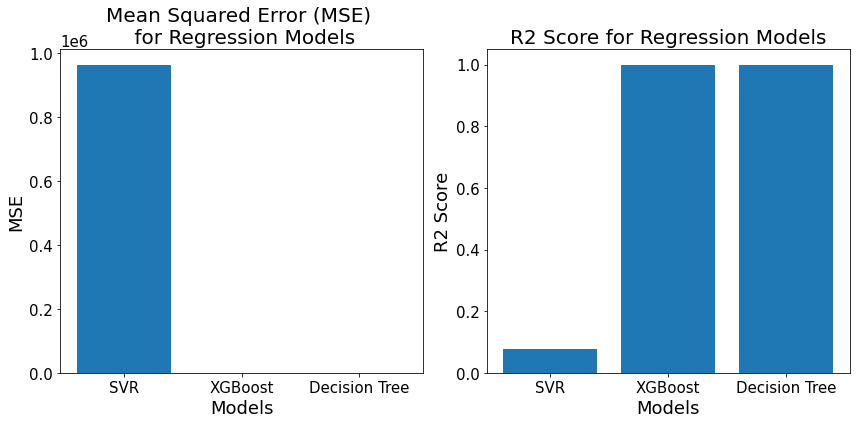

In [34]:
# Calculate MSE and R2 Score for each model
mse_scores = [mean_squared_error(y_test, y_pred_svr),
              mean_squared_error(y_test, y_pred_xgb),
              mean_squared_error(y_test, y_pred_dt)]

r2_scores = [r2_score(y_test, y_pred_svr),
             r2_score(y_test, y_pred_xgb),
             r2_score(y_test, y_pred_dt)]

# Create a bar plot
models = ['SVR', 'XGBoost', 'Decision Tree']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot MSE scores
ax1.bar(models, mse_scores)
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE')
ax1.set_title('Mean Squared Error (MSE) \n for Regression Models')

# Plot R2 scores
ax2.bar(models, r2_scores)
ax2.set_xlabel('Models')
ax2.set_ylabel('R2 Score')
ax2.set_title('R2 Score for Regression Models')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

**When PCA is employed to capture $80%$ of the variance, the three machine learning algorithms show distinct performance levels and computational time.**

- The Support Vector Regression (SVR) presents the highest Mean Squared Error $MSE$ of $951,777.07$ and the lowest $R^2$ Score of $0.0873$, indicating the poorest performance among the models tested. However, it comes with the longest execution time of approximately $9.98$ seconds.

- The XGBoost Regressor, in comparison, demonstrates a substantially better performance with an $MSE$ of $174,359.59$ and an $R^2$ Score of $0.8328$. Furthermore, it requires $6.67$ seconds to run, which is a shorter period compared to the SVR.

- Finally, the Decision Tree Regressor achieves an intermediate performance with an $MSE$ of $369,423.23$ and an $R^2$ Score of $0.6457$. This algorithm is the fastest, completing the computation in $1.11$ seconds.

**In contrast, when all variables are used instead of PCA, each algorithm's performance changes significantly.**

- The SVR shows similar performance in terms of $MSE$ $962,538.11$ and $R^2$ Score $0.0770$ to the PCA scenario, but the execution time drastically increases to approximately $1$ minute and $9$ seconds, making it the slowest by far.

- On the other hand, XGBoost and Decision Tree algorithms both achieve almost perfect predictions. The XGBoost model achieves an extremely low $MSE$ of $518.64$ and an $R^2$ Score of $0.9995$ in $6.01$ seconds, while the Decision Tree model produces an $MSE$ of $759.44$ and an $R^2$ Score of $0.9993$ in a record time of $732$ milliseconds.

**Summary:**
`Using all variables provides superior predictive results for`**`XGBoost and Decision Tree models`**`compared to PCA with 80% variance, but at the expense of increased computation time, especially noticeable in SVR.`

## Inferences

In [35]:
# Save the models
pickle.dump(svr_model, open("svr_model.pkl", 'wb'))
pickle.dump(xgb_model, open("xgb_model.pkl", 'wb'))
pickle.dump(dt_model, open("dt_model.pkl", 'wb'))

In [36]:
# Load the models
svr_model_loaded = pickle.load(open("svr_model.pkl", 'rb'))
xgb_model_loaded = pickle.load(open("xgb_model.pkl", 'rb'))
dt_model_loaded = pickle.load(open("dt_model.pkl", 'rb'))